In [1]:
#Code 3 (reads in master_df_with_features and runs a Pearson's correlation analysis)
#Optional to run

%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('output/master_df_with_features.xlsx')

In [3]:
# ---------------------------------------------------------
# 2. DEFINE TARGET (Y) AND FEATURES (X)
# ---------------------------------------------------------
target = 'Access_Disruption_Risk_Index_RMS'

# List of engineered features from previous step
feature_cols = [                      # Note to self: reflects final_features_to_cluster
    # --- PLAN MIX ---
    'feat_pct_bronze',                # % bronze enrollees
    'feat_pct_gold',                  # % gold enrollees
    #'plan_value_density',            # %gold enrollees divided by (%gold + %bronze enrollees)

    # --- INCOME LEVEL ---
    'feat_pct_FPL_100_150',         # % enrollees 100-150% FPL
    'feat_pct_FPL_150_250',         # % enrollees 150-250% FPL
    'feat_pct_FPL_250_400',         # % enrollees 250-400% FPL
    'feat_pct_FPL_400_plus',       # % enrollees 400%+ FPL

    # --- COST & VALUE ---
    'avg_premium_before_APTC',          # avg premium before APTC in dollars
    'feat_subsidy_coverage_ratio',      # (avg premium (before) - avg premium (after))/avg premium (before)
    
    # --- MARKET BEHAVIOR ---
    'feat_net_attrition',               # net attrition
    'feat_market_newness',              # % of new enrollees
    'feat_passive_renewal',             # % of enrollees with automatic/passive renewal
    
    # --- DEMOGRAPHICS ---
    #'feat_pct_age_18_34',              # % of enrollees 18-34
    'feat_pct_age_55_over',             # % of enrollees 55+yo
    'feat_pct_black',                   # % of enrollees who are African American
    'feat_pct_hispanic',                # % of enrollees who are Hispanic
    'feat_pct_asian',                   # % of enrollees who are Asian
    'feat_pct_aian',                    # % of enrollees who are American Indian/Alaska Native
    #'feat_pct_white'                   # % of enrollees who are White; exclude from clustering but then include when evaluating clusters
]

# Ensure all columns exist (handle cases where churn might be missing)
available_features = [col for col in feature_cols if col in df.columns]

In [4]:
# ---------------------------------------------------------
# 3. HIGH-LEVEL DATA EXPLORATION
# ---------------------------------------------------------
print("\n--- Summary Statistics (Features & Target) ---")
# describe() gives count, mean, std, min, 25%, 50%, 75%, max
stats = df[available_features + [target]].describe().transpose()
print(stats[['mean', 'std', 'min', 'max']].round(2))

# Check for remaining missing values
print("\n--- Missing Values Check ---")
missing = df[available_features + [target]].isnull().sum()
print(missing[missing > 0])


--- Summary Statistics (Features & Target) ---
                                    mean     std     min      max
feat_pct_bronze                    35.47   16.90    0.00    92.35
feat_pct_gold                      12.54   15.90    0.00    82.35
feat_pct_FPL_100_150               40.46   20.00    0.00    91.27
feat_pct_FPL_150_250               30.59    7.21    0.00    58.24
feat_pct_FPL_250_400               17.51    9.37    0.00    44.31
feat_pct_FPL_400_plus               7.69    6.07    0.00    35.77
avg_premium_before_APTC           709.70  160.23  414.00  1483.00
feat_subsidy_coverage_ratio         0.85    0.08    0.45     1.00
feat_net_attrition                  6.12   10.63    0.00   100.00
feat_market_newness                15.44    4.12    0.00    50.00
feat_passive_renewal               47.09   14.08    0.00    82.43
feat_pct_age_55_over               27.86    7.02    0.00    59.70
feat_pct_black                      2.47    4.57    0.00    38.03
feat_pct_hispanic           

In [5]:
# ---------------------------------------------------------
# 4. CORRELATION ANALYSIS (Pearson)
# ---------------------------------------------------------
# Calculate the correlation matrix
corr_matrix = df[available_features + [target]].corr()

# Extract correlations with the Target
target_corr = corr_matrix[target].sort_values(ascending=False)

print("\n--- Correlation with Access Disruption Risk Index ---")
print("(Positive = Increases Risk, Negative = Decreases Risk)")
print(target_corr.drop(target)) # Drop self-correlation


--- Correlation with Access Disruption Risk Index ---
(Positive = Increases Risk, Negative = Decreases Risk)
feat_pct_FPL_100_150           0.454035
feat_passive_renewal           0.417520
feat_subsidy_coverage_ratio    0.319591
feat_pct_black                 0.285876
feat_pct_age_55_over           0.160363
avg_premium_before_APTC        0.124736
feat_market_newness            0.115821
feat_pct_hispanic              0.088950
feat_pct_FPL_400_plus         -0.004901
feat_pct_asian                -0.015593
feat_pct_gold                 -0.015996
feat_pct_bronze               -0.207270
feat_pct_aian                 -0.253080
feat_pct_FPL_250_400          -0.277411
feat_pct_FPL_150_250          -0.286726
feat_net_attrition            -0.472469
Name: Access_Disruption_Risk_Index_RMS, dtype: float64


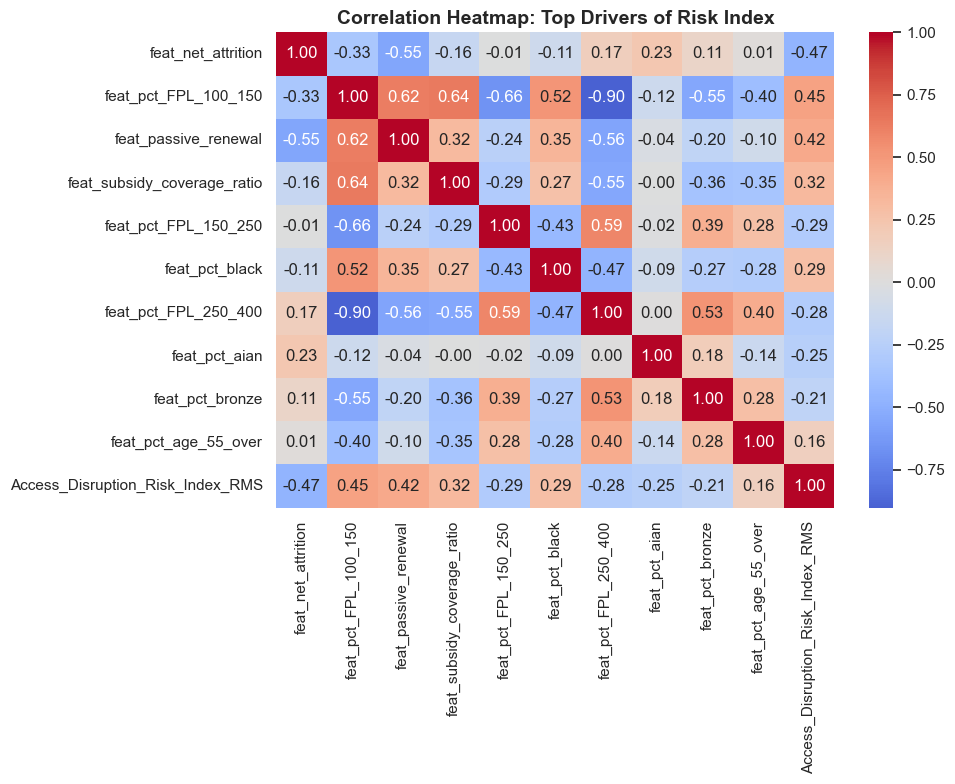

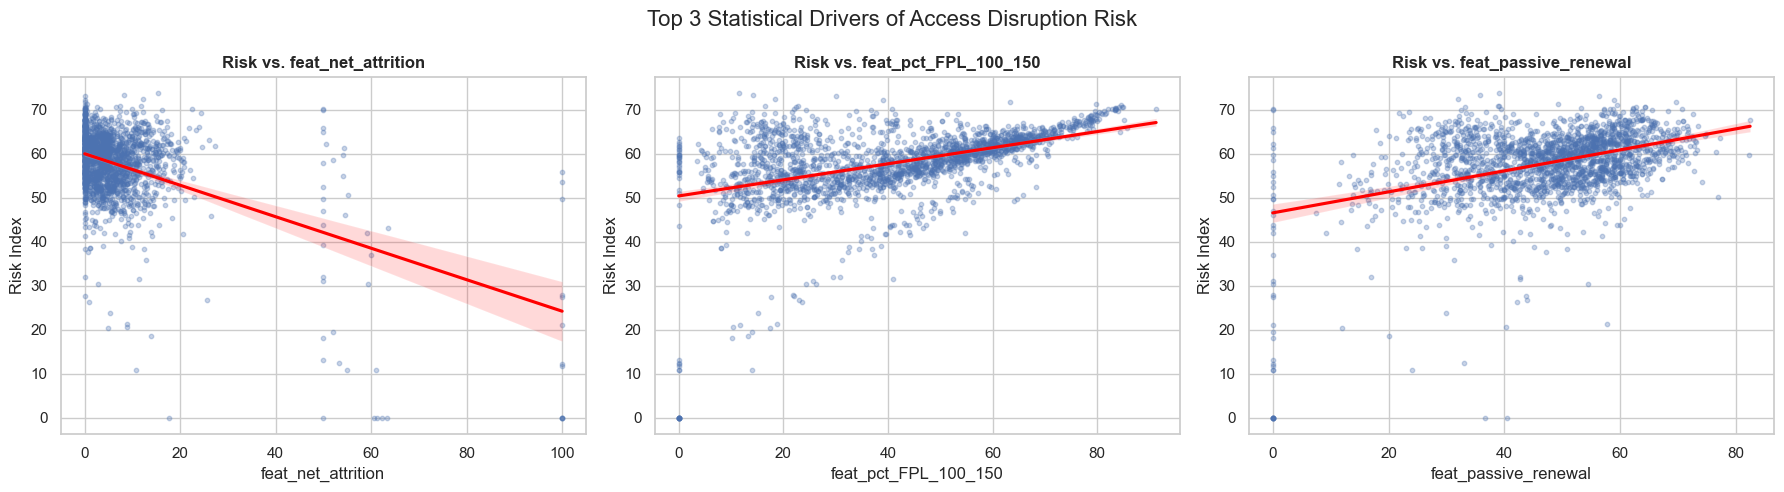

In [6]:
# ---------------------------------------------------------
# 5. VISUALIZATION
# ---------------------------------------------------------
sns.set_theme(style="whitegrid")

# A. Correlation Heatmap (Top 10 strongest features only for readability)
# Get top 5 positive and top 5 negative correlations
top_corr_features = target_corr.drop(target).abs().sort_values(ascending=False).head(10).index.tolist()
heatmap_data = df[top_corr_features + [target]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Correlation Heatmap: Top Drivers of Risk Index', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# B. Scatter Plots of Top 3 Drivers
# visualizing the linear relationship
top_3_drivers = top_corr_features[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_3_drivers):
    sns.regplot(data=df, x=feature, y=target, ax=axes[i], 
                scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
    
    axes[i].set_title(f'Risk vs. {feature}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Risk Index')

plt.suptitle(f'Top 3 Statistical Drivers of Access Disruption Risk', fontsize=16)
plt.tight_layout()
plt.show()